In [10]:
import os #ghép đường dẫn file ảnh
import numpy as np #thao tác mảng số
import pandas as pd #đọc CSV, thao tác bảng
import matplotlib.pyplot as plt # vẽ biểu đồ loss/accuracy và hiển thị ảnh
from sklearn.model_selection import train_test_split #chia dữ liệu train/validation
from sklearn.metrics import confusion_matrix, classification_report #đánh giá chi tiết
import tensorflow as tf # framework deep learning
from tensorflow.keras import layers, models #xây model, train, predict
from tensorflow.keras.preprocessing.image import ImageDataGenerator #đọc ảnh theo batch + augmentation
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input


In [14]:
# =====================
# CONFIG (Cấu hình)
# =====================
IMG_DIR   = r"D:/Hocmay/ga/Train" #folder chứa ảnh
CSV_PATH  = r"D:/Hocmay/ga/train_data.csv" #file csv chứa tên ảnh + label

IMG_SIZE = (224, 224)      # ResNet50 chuẩn 224x224
BATCH_SIZE = 32            # mỗi lần cập nhật trọng số, model nhìn 32 ảnh
EPOCHS_FE = 5              # số vòng train Feature Extraction
EPOCHS_FT = 8              # số vòng train Fine-tuning
SEED = 42                  # giúp kết quả chia train/val “ổn định” (lần chạy sau giống lần trước)

tf.random.set_seed(SEED) #cố định tính ngẫu nhiên (random) của TensorFlow (Khởi tạo trọng số ban đầu của mạng, tắt neuron, xoay, lật ảnh)
np.random.seed(SEED) #Cố định random của NumPy (Chia train/va, Tạo số ngẫu nhiên)
# Nếu ko set mỗi lần chạy lại code kết quả khác nhau

print("TF:", tf.__version__)
# Kiểm tra TensorFlow có nhận GPU không
print("GPU:", tf.config.list_physical_devices('GPU'))


TF: 2.20.0
GPU: []


In [15]:
df = pd.read_csv(CSV_PATH)

# CSV có 2 cột: images, label
#tạo cột filepath chứa đường dẫn ảnh
df["filepath"] = df["images"].apply(lambda x: os.path.join(IMG_DIR, x))

# Lọc ảnh bị thiếu (nếu có)
df = df[df["filepath"].apply(os.path.exists)].reset_index(drop=True)

print(df.head())
print("Tổng ảnh:", len(df))
print("Số lớp:", df["label"].nunique())
print(df["label"].value_counts())


           images               label                           filepath
0  salmo.1558.jpg          Salmonella  D:/Hocmay/ga/Train\salmo.1558.jpg
1  cocci.1866.jpg         Coccidiosis  D:/Hocmay/ga/Train\cocci.1866.jpg
2   cocci.171.jpg         Coccidiosis   D:/Hocmay/ga/Train\cocci.171.jpg
3  salmo.1484.jpg          Salmonella  D:/Hocmay/ga/Train\salmo.1484.jpg
4     ncd.100.jpg  New Castle Disease     D:/Hocmay/ga/Train\ncd.100.jpg
Tổng ảnh: 8067
Số lớp: 4
label
Salmonella            2625
Coccidiosis           2476
Healthy               2404
New Castle Disease     562
Name: count, dtype: int64


In [16]:
#Chia dữ liệu cho tập train/test
train_df, val_df = train_test_split(
    df, test_size=0.2, random_state=SEED, stratify=df["label"]
)
#stratify giữ nguyên tỉ lệ các lớp (label) ở cả train và val
print("Train:", len(train_df), "Val:", len(val_df))


Train: 6453 Val: 1614


In [19]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, #chuẩn hoá ảnh theo đúng kiểu ResNet50 pretrained
    rotation_range=15, #xoay +-15 độ
    width_shift_range=0.1, # Dịch ngang lên đến 10% chiều rộng ảnh --> học được vị trí vật thể không cố định trong ảnh
    height_shift_range=0.1, # Dịch dọc lên đến 10% chiều cao ảnh --> tăng khả năng nhận dạng bất chấp vật thể ở vị trí khác
    zoom_range=0.1, # Phóng to/thu nhỏ ảnh trong khoảng ±20% 
    horizontal_flip=True #Lật ngang --> Hữu ích cho ảnh đối xứng
)

#validation KHÔNG dùng augmentation do phải dùng dữ liệu giống thật ngoài đời
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Tạo generator cho tập huấn luyện
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical", #nhãn được one-hot (vd [0,0,1,0])
    batch_size=BATCH_SIZE,
    shuffle=True, #để model không học theo thứ tự cố định
    seed=SEED
)

# Tạo generator cho tập validation
val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False #Giữ nguyên thứ tự ảnh trong validation
)

# Lấy tên các lớp
NUM_CLASSES = len(train_gen.class_indices)
print("Classes:", train_gen.class_indices)
print("NUM_CLASSES:", NUM_CLASSES)


Found 6453 validated image filenames belonging to 4 classes.
Found 1614 validated image filenames belonging to 4 classes.
Classes: {'Coccidiosis': 0, 'Healthy': 1, 'New Castle Disease': 2, 'Salmonella': 3}
NUM_CLASSES: 4


In [ ]:
#Load ResNet50 pretrained + đóng băng (Feature Extraction)
base_model = ResNet50(
    weights="imagenet", #lấy trọng số học sẵn trên ImageNet
    include_top=False,#bỏ phần “head” gốc của ResNet50 (1000 lớp ImageNet)
    input_shape=(*IMG_SIZE, 3)
)
base_model.trainable = False  # đóng băng, chỉ train phần head mình thêm, không cập nhật ResNet50

#Gắn head mới
#Nhận ảnh và biến ảnh thành feature map
# Feature map Là các đặc trưng trừu tượng: cạnh, góc, texture, hình dạng,mẫu phức tạp (mắt, cánh, tổn thương…)
inputs = layers.Input(shape=(*IMG_SIZE, 3))
# BN có 2 kiểu hành vi:
# Khi training: dùng thống kê mean/var của batch hiện tại
# Khi inference: dùng thống kê running mean/var đã lưu
# Khi freeze backbone, thường muốn BN chạy như inference (ổn định), nên để training=False.
x = base_model(inputs, training=False)          # training=False dùng thống kê batch hiện tại, giúp BatchNorm ổn định khi freeze

# ResNet50 (include_top=False) trả ra feature map dạng (H, W, C), ví dụ: (7, 7, 2048)
# C=2048 kênh: mỗi kênh như một “bộ dò đặc trưng”.
# GlobalAveragePooling2D sẽ:
# Lấy trung bình trên toàn bộ H×W cho từng kênh (7,7,2048) → (2048)
# Tức là biến “bản đồ đặc trưng” thành vector đặc trưng gọn.
x = layers.GlobalAveragePooling2D()(x) # Mỗi feature map = “máy dò” 1 đặc trưng (ví dụ: viền, đốm, kết cấu…), Nó lấy trung bình của MỖI feature map

x = layers.BatchNormalization()(x)  #Chuẩn hoá các giá trị trong vector đặc trưng để chúng có phân phối ổn định hơn

# Trong lúc train:random tắt 40% neuron, mỗi batch tắt neuron khác nhau
# Tránh model học thuộc lòng. Bắt model học đặc trưng tổng quát hơn
x = layers.Dropout(0.4)(x)

#softmax biến 3 số đó thành xác suất (tổng = 1)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = models.Model(inputs, outputs)#Tạo model với đầu vào là inputs và đầu ra là outputs
model.summary() #in ra kiến trúc: số layer, shape từng tầng, số tham số.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,604,100 (90.04 MB)

 Trainable params: 12,292 (48.02 KB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3), #thuật toán cập nhật trọng số, sau mỗi lần model đoán sai điều chỉnh trọng số để đoán đúng hơn lần sau
    loss="categorical_crossentropy", #Là thước đo độ sai, Model cố gắng giảm loss xuống thấp nhất
    metrics=["accuracy"]
)

#những thứ tự động can thiệp trong lúc train
callbacks = [
    tf.keras.callbacks.ModelCheckpoint( #Tự động lưu model tốt nhất trong lúc train
        "resnet50_best.keras", #File model tốt nhất (có thể load lại sau)
        monitor="val_accuracy", #Theo dõi accuracy trên validation
        save_best_only=True, #Chỉ lưu khi val_accuracy tăng
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping( #Nếu model không còn tiến bộ nữa dừng train
        monitor="val_accuracy", 
        patience=3, #Nếu 3 epoch liên tiếp mà val_accuracy không tăng dừng training
        restore_best_weights=True #Sau khi dừng → quay lại trọng số tốt nhất
    ),
    #Model học tốt lúc đầu, sau đó val_loss không giảm nữa, có thể do learning rate quá lớn
    tf.keras.callbacks.ReduceLROnPlateau( #giảm LR
        monitor="val_loss",
        factor=0.5, #Learning rate mới = learning rate cũ × 0.5
        patience=2,
        verbose=1
    )
]


In [ ]:
history_fe = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_FE,
    callbacks=callbacks,
)
# accuracy -  độ chính xác trên tập huấn luyện (training set) 
# loss - giá trị hàm mất mát (loss function) trên tập huấn luyện
# val_accuracy - độ chính xác trên tập kiểm định (validation set)
# val_loss - giá trị mất mát trên tập validation

Epoch 1/5
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7318 - loss: 0.7719
Epoch 1: val_accuracy improved from None to 0.91884, saving model to resnet50_best.keras

Epoch 1: finished saving model to resnet50_best.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 508s 2s/step - accuracy: 0.8236 - loss: 0.5096 - val_accuracy: 0.9188 - val_loss: 0.2317 - learning_rate: 0.0010
Epoch 2/5
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9009 - loss: 0.2923
Epoch 2: val_accuracy improved from 0.91884 to 0.93309, saving model to resnet50_best.keras

Epoch 2: finished saving model to resnet50_best.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 298s 1s/step - accuracy: 0.9028 - loss: 0.2973 - val_accuracy: 0.9331 - val_loss: 0.1973 - learning_rate: 0.0010
Epoch 3/5
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9099 - loss: 0.2713
Epoch 3: val_accuracy did not improve from 0.93309
202/202 ━━━━━━━━━━━━━━━━━━━━ 294s 1s/step - accuracy: 0.9098 - loss: 0.2709 - val_accuracy: 0.9281 - val_loss: 0.2174 - le

In [ ]:
#Fine-tuning = mở một phần ResNet50 để học tinh chỉnh đặc trưng cho bài toán
base_model.trainable = True #Cho phép ResNet50 có thể được cập nhật trọng số

# Chỉ mở 30 layer cuối
fine_tune_at = len(base_model.layers) - 30
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

#giảm learning rate xuống 1e-5 do:
# Feature Extraction: Train từ đầu head cần học nhanh
# Fine-tuning: Chỉ chỉnh nhẹ các layer đã học sẵn
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_FT,
    callbacks=callbacks,
)


Epoch 1/8
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9221 - loss: 0.2297
Epoch 1: val_accuracy improved from 0.93680 to 0.94919, saving model to resnet50_best.keras

Epoch 1: finished saving model to resnet50_best.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.9267 - loss: 0.2151 - val_accuracy: 0.9492 - val_loss: 0.1699 - learning_rate: 1.0000e-05
Epoch 2/8
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9443 - loss: 0.1696
Epoch 2: val_accuracy did not improve from 0.94919
202/202 ━━━━━━━━━━━━━━━━━━━━ 1132s 6s/step - accuracy: 0.9434 - loss: 0.1663 - val_accuracy: 0.9492 - val_loss: 0.1645 - learning_rate: 1.0000e-05
Epoch 3/8
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9412 - loss: 0.1678
Epoch 3: val_accuracy improved from 0.94919 to 0.95663, saving model to resnet50_best.keras

Epoch 3: finished saving model to resnet50_best.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 707s 4s/step - accuracy: 0.9456 - loss: 0.1568 - val_accuracy: 0.9566 - val_loss:

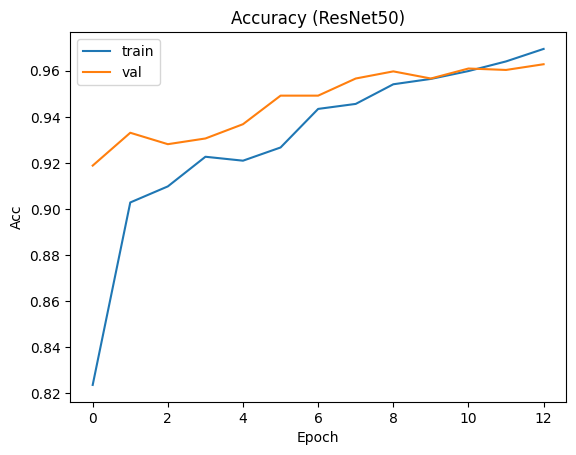

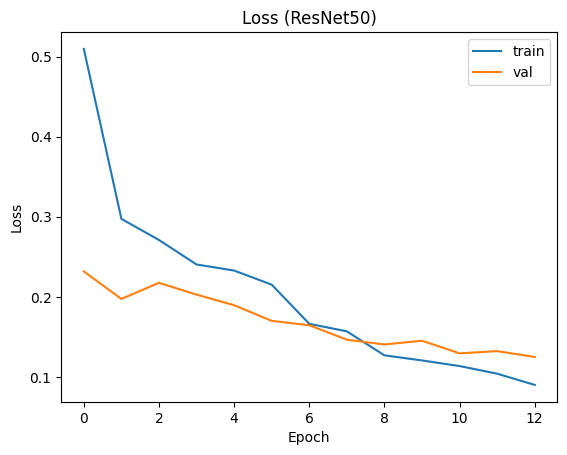

In [ ]:
#nối 2 history lại thành 1
def merge_histories(h1, h2): 
    out = {}
    for k in h1.history.keys():
        out[k] = h1.history[k] + h2.history.get(k, []) #Nối list của 2 giai đoạn
    return out

hist = merge_histories(history_fe, history_ft)

plt.figure()
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Accuracy (ResNet50)")
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend(["train", "val"])
plt.show()

plt.figure()
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Loss (ResNet50)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "val"])
plt.show()


In [ ]:
#lưu TOÀN BỘ mô hình vào file và Load lại mô hình đã lưu
model.save("resnet50_final.keras")

In [ ]:
#Load lại mô hình đã lưu
import tensorflow as tf

loaded = tf.keras.models.load_model("resnet50_final.keras")
loaded.evaluate(val_gen) #Đánh giá mô hình trên validation [loss, accuracy]

51/51 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9628 - loss: 0.1248


[0.12482056021690369, 0.9628252983093262]

51/51 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step


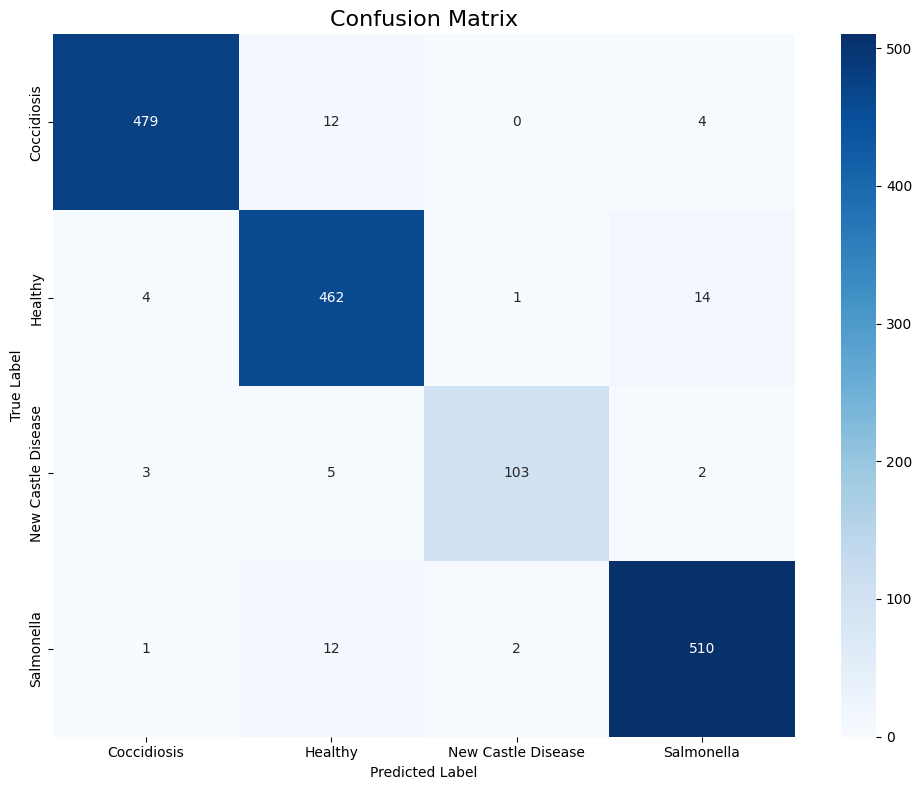

                    precision    recall  f1-score   support

       Coccidiosis       0.98      0.97      0.98       495
           Healthy       0.94      0.96      0.95       481
New Castle Disease       0.97      0.91      0.94       113
        Salmonella       0.96      0.97      0.97       525

          accuracy                           0.96      1614
         macro avg       0.96      0.95      0.96      1614
      weighted avg       0.96      0.96      0.96      1614



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

#dự đoán trên validation
val_gen.reset() #đưa con trỏ về đầu
pred_probs = loaded.predict(val_gen) #xác suất dự đoán cho mỗi lớp
y_pred = np.argmax(pred_probs, axis=1) #Chọn lớp có xác suất lớn nhất cho từng ảnh
y_true = val_gen.classes #Nhãn thật (ground truth) đã được generator gán sẵn
 
#train_gen.class_indices{'Coccidiosis': 0,...}
#idx_to_label đảo ngược lại {0:'Coccidiosis'}
idx_to_label = {v: k for k, v in train_gen.class_indices.items()}
labels_sorted = [idx_to_label[i] for i in range(NUM_CLASSES)] #Tạo list nhãn theo đúng thứ tự index['Coccidiosis','Salmonella',...]


cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels_sorted,
    yticklabels=labels_sorted
)

plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# 5. Classification report
print(classification_report(y_true, y_pred, target_names=labels_sorted))


Ảnh test: D:/Hocmay/ga/Train\pcrsalmo.23.jpg
Nhãn thật: Salmonella


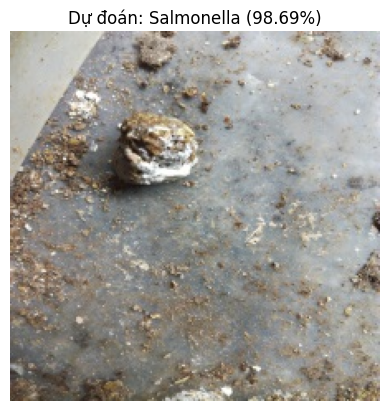

Ảnh được dự đoán là: Salmonella
Độ tin cậy: 98.69%


('Salmonella',
 np.float32(98.688446),
 array([[4.2459655e-05, 1.2806430e-02, 2.6655738e-04, 9.8688447e-01]],
       dtype=float32))

In [21]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# mapping index -> label như trên
idx_to_label = {v: k for k, v in val_gen.class_indices.items()}

def predict_image(img_path, model, img_size=IMG_SIZE):
    # 1. Load ảnh và resize
    img = image.load_img(img_path, target_size=img_size)

    # 2. Chuyển sang array + batch
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # 3. Preprocess chuẩn ResNet50
    x = preprocess_input(x)

    # 4. Predict
    preds = model.predict(x, verbose=0)
    idx = int(np.argmax(preds))
    predicted_class = idx_to_label[idx]
    confidence = preds[0][idx] * 100

    # 5. Hiển thị ảnh + kết quả
    plt.imshow(img)
    plt.title(f"Dự đoán: {predicted_class} ({confidence:.2f}%)")
    plt.axis("off")
    plt.show()

    print(f"Ảnh được dự đoán là: {predicted_class}")
    print(f"Độ tin cậy: {confidence:.2f}%")

    return predicted_class, confidence, preds

# Lấy ngẫu nhiên 1 ảnh trong tập validation
sample = val_df.sample(1, random_state=42)

img_path = sample["filepath"].values[0]
true_label = sample["label"].values[0]

print("Ảnh test:", img_path)
print("Nhãn thật:", true_label)

predict_image(img_path, loaded)